In [ ]:
# default_exp embeddings

# Sentence Embedding Callback

> fast.ai ULMFiT callback to extract sentence embeddings

Pooling functions taken from user **arampacha** https://forums.fast.ai/t/encodings-from-the-sentence-encoder/80146/5

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#all_slow

In [ ]:
#export
import torch
import torch.nn.functional as F
from fastcore.basics import store_attr
from fastai.torch_core import rank_distrib
from fastai.callback.hook import hook_output
from fastai.callback.core import Callback
from fastai.text.models import masked_concat_pool

In [ ]:
#export
def _masked_max_pool(output, mask, bptt):
    return output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]

def _last_hdn_pool(output, mask, bptt):
    last_lens = mask[:,-bptt:].long().sum(dim=1)
    return output[torch.arange(0, output.size(0)),-last_lens-1]

def _masked_avg_pool(output, mask, bptt):
    lens = output.shape[1] - mask.long().sum(dim=1)
    avg_pool = output.masked_fill(mask[:, :, None], 0).sum(dim=1)
    avg_pool.div_(lens.type(avg_pool.dtype)[:,None])
    return avg_pool

_pooler = {
    'concat': masked_concat_pool,
    'max': _masked_max_pool,
    'last': _last_hdn_pool,
    'avg': _masked_avg_pool,
}

In [ ]:
#export
class SentenceEmbeddingCallback(Callback):
    def __init__(self, pool_mode='concat'):
        store_attr()
        self.pooler = _pooler[pool_mode]
        
        
    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and hasattr(self, "gather_preds") and rank_distrib()==0
        if self.run:
            self._setup()
    
    def after_pred(self):  
        feat = self.feat
        hook = self.hook
        
        first_epoch = True if self.learn.iter == 0 else False

        bptt = getattr(self.sentence_encoder, 'bptt')

        enc = hook.stored[0]
        mask = hook.stored[1]
        vec = self.pooler(enc, mask, bptt).detach().cpu()
        
        preds = F.softmax(self.learn.pred, dim=1).detach().cpu().argmax(dim=1)
        feat['pred'] = preds if first_epoch else torch.cat((feat['pred'], preds),0)

        learn = self.learn
        dec = learn.dl.decode_batch((learn.x,learn.y), max_n=len(learn.x))
        dec_lists = list(map(list, zip(*dec)))
        texts = dec_lists[0]
        #texts = [t.replace('\t','').replace('\n','').replace('xxbos ','').replace('xxup ','').replace('xxmaj ','').replace(' ', '').replace('▁', ' ') for t in texts]
        feat['text'] = texts if first_epoch else feat['text'] + texts

        feat['vec'] = vec if first_epoch else torch.cat((feat['vec'], vec),0)
        if hasattr(learn, 'y'):
            y = learn.y.detach().cpu()
            feat['y'] = y          if first_epoch else torch.cat((feat['y'], y),0)
            
    def after_validate(self):
        self._remove()

        
    def _setup(self):
        self.sentence_encoder = self.learn.model[0]
        self.hook = hook_output(self.sentence_encoder)
        self.feat = {}
        
    def _remove(self):
        if getattr(self, 'hook', None): self.hook.remove()

    def __del__(self): self._remove()

# Test Sentence Embedding Callback

Fine-Tune model on AG_NEWS dataset, extract embeddings and visualize them with matplotlib

In [ ]:
#hide
from fastai.text.all import *
path = untar_data(URLs.AG_NEWS)
df = pd.read_csv(path/'test.csv',header=None)
dls = TextDataLoaders.from_df(df, text_col=2, label_col=0)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(3, 3e-3)

/home/florian/miniconda3/envs/fastai-ulmfit/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


epoch,train_loss,valid_loss,accuracy,time
0,0.717966,0.475415,0.834868,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.506675,0.393058,0.864474,00:06
1,0.455751,0.371491,0.872368,00:06
2,0.371775,0.356939,0.874342,00:06


In [ ]:
#hide
se_callback = SentenceEmbeddingCallback(pool_mode='concat')
preds = learn.get_preds(cbs=[se_callback])

feat = se_callback.feat

In [ ]:
#hide
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(feat['vec'])
coords = pca.transform(feat['vec'])
target_labels = [dls.vocab[1][l] for l in feat['y']]
pred_labels = [dls.vocab[1][l] for l in feat['pred']]
df_preds = pd.DataFrame({'x': coords[:,0], 'y': coords[:,1], 
                         'text': feat['text'], 
                         'target_labels': target_labels, 
                         'pred_labels': pred_labels, 
                         'color': feat['y']})

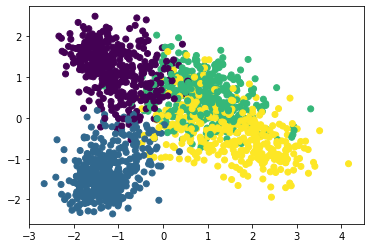

In [ ]:
#hide
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(df_preds['x'].tolist(), df_preds['y'].tolist(), c=df_preds['pred_labels'].tolist(), cmap='viridis')